In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Labelled set

In [ ]:
# Load renamed ADL falls dataset
df = pd.read_csv("./ADL_labelling_c17.csv")


In [72]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117795 entries, 0 to 117794
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   yaw_mean                           117795 non-null  float64
 1   pitch_mean                         117795 non-null  float64
 2   roll_mean                          117795 non-null  float64
 3   rotation_rate_x_mean               117795 non-null  float64
 4   rotation_rate_y_mean               117795 non-null  float64
 5   rotation_rate_z_mean               117795 non-null  float64
 6   user_acceleration_x_mean           117795 non-null  float64
 7   user_acceleration_z_mean           117795 non-null  float64
 8   pitch_std                          117795 non-null  float64
 9   speed_mean                         117795 non-null  float64
 10  speed_std                          117795 non-null  float64
 11  course_mode                        1177

In [73]:
print(df['activity_label'].unique())

['chores' 'eat' 'hobby' 'exercise' 'relax' 'sleep' 'errands' 'hygiene'
 'entertainment']


In [74]:
df = df.drop(columns='activity_instance')

## Pipeline and training on labelled set

### Imputation not necessary

In [75]:
# Detecting missing values
missing_list = list(df.columns[df.isna().any()])       

# Percentage of missing values
row_count = df.shape[0] 
# Create list of dicts (one per column)
data = []
for col in missing_list:
    count = df[col].isnull().sum()
    percent = (count / row_count) * 100
    data.append({
        'Columns with missing values': col,
        'Missing count': count,
        'Missing %': percent,
        'DataType' : df[col].dtype
    })

# Create DataFrame from list of dicts
missing_df = pd.DataFrame(data)
print(missing_df)

Empty DataFrame
Columns: []
Index: []


### Pipeline creation

In [76]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# Nominal features to be one-hot encoded
# If activity labels are limited: ['Eat' 'Climbing stairs' 'Fall' 'Run' 'Other exercise' 'Sleep' 'Sitting down' 'Walk']
nominal_cols_encode = ['distance_from_home_mean_bin_fixed']

# Numerical features to be imputed and scaled
numerical_cols_scale = df.select_dtypes(include='number').columns.tolist()

nominal_onehot_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_scale_pipe = Pipeline([ # to add skew correction
    ('scaler', StandardScaler())
])

print(numerical_cols_scale)
print(len(nominal_cols_encode)+len(numerical_cols_scale)) 

['yaw_mean', 'pitch_mean', 'roll_mean', 'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean', 'user_acceleration_x_mean', 'user_acceleration_z_mean', 'pitch_std', 'speed_mean', 'speed_std', 'course_mode', 'course_std', 'distance_from_home_latitude_mean', 'distance_from_home_longitude_mean', 'bearing_from_home_mode', 'bearing_from_home_std', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week', 'duration_minutes', 'day_of_week_sin', 'day_of_week_cos', 'duration_zscore_user_all_acts', 'duration_zscore_user_each_act', 'total_orientation_variability', 'total_orientation', 'speed_n_orientation_stability', 'duration_n_daily_freq', 'duration_n_weekly_freq']
31


In [77]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal_encode', nominal_onehot_pipe, nominal_cols_encode),
        ('num_scale', numerical_scale_pipe, numerical_cols_scale)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1
    )


### Train test split

In [78]:
# Check the distribution of the target column
print(df['activity_label'].value_counts())

activity_label
chores           23691
relax            21682
eat              13879
hobby            13814
entertainment    11688
exercise         11537
errands           9147
sleep             7135
hygiene           5222
Name: count, dtype: int64


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

X = df.drop(columns=['activity_label'])
y = df['activity_label']

# -----------------
# Balanced data:
# -----------------
# Split the data into training and test sets, ensuring stratification
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# y_train = y_train.map({'Healthy': 0, 'Unhealthy': 1})
# y_test = y_test.map({'Healthy': 0, 'Unhealthy': 1})

# -----------------
# Imbalanced data:
# -----------------
# Split the data into training and test sets, ensuring stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split the test-validation set (20%) into validation (10%) and test (10%) sets
# X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42, stratify=y_testval)




# # Combine training features and target for resampling
# train_df = pd.concat([X_train, y_train], axis=1)

# # Separate majority and minority classes in the training set only
# train_majority = train_df[train_df.health_status == 0]
# train_minority = train_df[train_df.health_status == 1]

# len_maj = len(train_majority)
# len_min = len(train_minority)
# n_samples_each = round((len_maj+len_min)/2)
# print(n_samples_each)

# # Upsample minority class in the training set
# train_minority_upsampled = resample(train_minority, 
#                                     replace=True,    # sample with replacement
#                                     n_samples=n_samples_each,  # number of samples in upsampled minority class (reduced due to resource constraints)
#                                     random_state=42) # reproducible results

# # Downsample majority class in the training set
# train_majority_downsampled = resample(train_majority, 
#                                       replace=False,    # sample without replacement
#                                       n_samples=n_samples_each,   # number of samples in downsampled majority class (reduced due to resource constraints)
#                                       random_state=42)  # reproducible results

# # Combine upsampled minority class with downsampled majority class
# train_combined = pd.concat([train_majority_downsampled, train_minority_upsampled])

# # Shuffle and reset index
# train_combined = train_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# # Re-separate the features and target in the combined training set
# X_train = train_combined.drop(columns='health_status')
# y_train = train_combined['health_status']

# print(y_test.value_counts())
# print(y_train.value_counts())
# print(X_train.info())

In [80]:
print('Training data %:\n', y_train.value_counts(normalize=True))
print('Test data %:\n', y_test.value_counts(normalize=True))

Training data %:
 activity_label
chores           0.201123
relax            0.184070
eat              0.117821
hobby            0.117269
entertainment    0.099219
exercise         0.097946
errands          0.077656
sleep            0.060571
hygiene          0.044325
Name: proportion, dtype: float64
Test data %:
 activity_label
chores           0.201112
relax            0.184049
eat              0.117832
hobby            0.117280
entertainment    0.099240
exercise         0.097924
errands          0.077635
sleep            0.060571
hygiene          0.044357
Name: proportion, dtype: float64


### Baseline model (no resampling)

In [81]:
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score


# Models and names
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=30, random_state=42))
]
# CV strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42) # Robust evaluation on imbalanced data using RepeatedStratifiedKFold

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
    'roc_auc': 'roc_auc_ovr'
}


# Keep results for comparison
results = []

for name, clf in models:
    base_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

    # Calculate scores
    scores = cross_validate(
        base_pipeline, X_train, y_train, 
        scoring=scoring, 
        cv=cv, 
        n_jobs=-1,
        return_train_score=True
        )
    results.append({
        'Model': name,
        **{f"train_{metric}": scores[f"train_{metric}"].mean() for metric in scoring},
        **{f"val_{metric}": scores[f"test_{metric}"].mean() for metric in scoring}
    })

# Create DataFrame for comparison
results_df = pd.DataFrame(results)
print(results_df)


                 Model  train_accuracy  train_precision  train_recall  \
0  Logistic Regression        0.408997         0.409127      0.408997   
1        Random Forest        1.000000         1.000000      1.000000   

   train_f1  train_roc_auc  val_accuracy  val_precision  val_recall    val_f1  \
0  0.402861       0.820347      0.407806       0.407933    0.407806  0.401668   
1  1.000000       1.000000      1.000000       1.000000    1.000000  1.000000   

   val_roc_auc  
0     0.819494  
1     1.000000  


Random Forest baseline clearly overfitting.


### SMOTE + random undersampling

In [82]:
# Check the distribution of the target column
print(y_train.value_counts())

activity_label
chores           18953
relax            17346
eat              11103
hobby            11051
entertainment     9350
exercise          9230
errands           7318
sleep             5708
hygiene           4177
Name: count, dtype: int64


In [83]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# chores           18953
# relax            17346
# eat              11103
# hobby            11051
# entertainment     9350
# exercise          9230
# errands           7318
# sleep             5708
# hygiene           4177

# Step 1: Oversample minorities only (to ~9000)
smote = SMOTE(
    sampling_strategy={
        'errands': 9000,
        'hygiene': 9000,
        'sleep': 9000
    }, 
    random_state=42
)

# Step 2: Undersample only the two largest classes
under = RandomUnderSampler(
    sampling_strategy={
        'chores': 11000,
        'relax': 11000
    }, 
    random_state=42
)


In [84]:
# test using smote and under
from imblearn.pipeline import Pipeline

# Keep results for comparison
results = []

for name, clf in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('under', under),
        ('classifier', clf)
    ])

    # Calculate scores
    scores = cross_validate(
        pipeline, X_train, y_train, 
        scoring=scoring, 
        cv=cv, 
        n_jobs=-1,
        return_train_score=True
        )
    
    model_name = f'{name} (SMOTE + undersampling)'
    results.append({
        'Model': model_name,
        **{f"train_{metric}": scores[f"train_{metric}"].mean() for metric in scoring},
        **{f"val_{metric}": scores[f"test_{metric}"].mean() for metric in scoring}
    })

# Create DataFrame for comparison
new_results_df = pd.DataFrame(results)

# Get all new model names
new_model_names = new_results_df['Model'].tolist()

# Remove rows from results_df with the same model names
results_df = results_df[~results_df['Model'].isin(new_model_names)]

results_df = pd.concat([results_df, new_results_df], ignore_index=True)
print(results_df)

                                         Model  train_accuracy  \
0                          Logistic Regression        0.408997   
1                                Random Forest        1.000000   
2  Logistic Regression (SMOTE + undersampling)        0.396481   
3        Random Forest (SMOTE + undersampling)        1.000000   

   train_precision  train_recall  train_f1  train_roc_auc  val_accuracy  \
0         0.409127      0.408997  0.402861       0.820347      0.407806   
1         1.000000      1.000000  1.000000       1.000000      1.000000   
2         0.415947      0.396481  0.392646       0.819474      0.395465   
3         1.000000      1.000000  1.000000       1.000000      1.000000   

   val_precision  val_recall    val_f1  val_roc_auc  
0       0.407933    0.407806  0.401668     0.819494  
1       1.000000    1.000000  1.000000     1.000000  
2       0.415045    0.395465  0.391746     0.818690  
3       1.000000    1.000000  1.000000     1.000000  


* Random forest still overfitting.
* Logistic regression performance dropped.
* We can proceed without resampling since performance is not better.

### Feature importance checks

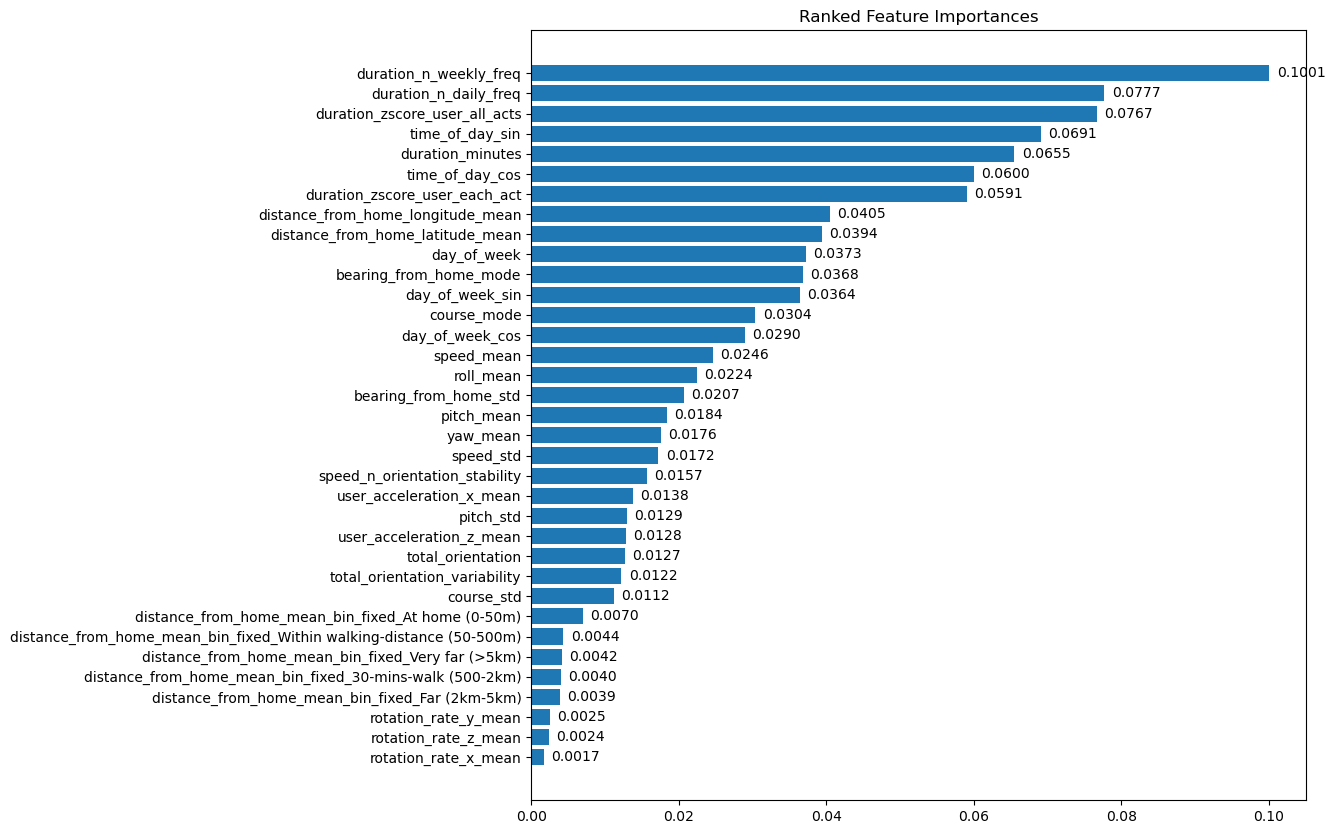

In [85]:
# Use Random Forest to extract feature importance
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('under', under),
        ('classifier', RandomForestClassifier(n_estimators=30, random_state=42))
    ])

# First, fit the pipeline
pipeline.fit(X_train, y_train)

# After fitting
rf = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf.feature_importances_

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,10))
bars = plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Ranked Feature Importances")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center')
plt.show()




Observations:
* no feature is over-dominating
* the most important feature is duration * weekly_frequency of activity, at 0.1
* least important features are rotation rate means

### Drop features that could be too highly correlated with activity

We removed temporal features such as: 

- Time, day of week and daytime since activities such as sleep almost always correlate ~1 to these. 

- Features such as speed or location could indicate location. 

- Total motion, motion variability and activity intensity were alsoo removed. 

We decided to use purely sensor data to derive the activity being performed.

In [ ]:
# SAFE FEATURES: Only motion and acceleration sensors
safe_sensor_features = [
    # Basic motion features (orientation)
    'yaw_mean', 'pitch_mean', 'roll_mean', 
    'yaw_std', 'pitch_std', 'roll_std',
    
    # Rotation rate features
    'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean',
    'rotation_rate_x_std', 'rotation_rate_y_std', 'rotation_rate_z_std',
    
    # User acceleration (device movement)
    'user_acceleration_x_mean', 'user_acceleration_z_mean',  # removed y due to correlation
    'user_acceleration_x_std', 'user_acceleration_z_std',
    
    # Magnitude features (overall activity intensity)
    'rotation_magnitude_mean', 'acceleration_magnitude_mean',
    'rotation_magnitude_std', 'acceleration_magnitude_std'
]

# REMOVED FEATURES (potential data leakage):
removed_features = [
    # Temporal features (highly correlated with activities)
    'time_of_day_radians', 'time_of_day_cos', 'time_of_day_sin',
    'hour', 'day_of_week', 'is_weekend', 'is_daytime',
    'day_of_week_sin', 'day_of_week_cos',
    
    # Location features (activities tied to locations)
    'distance_from_home_mean', 'distance_from_home_std',
    'distance_from_home_latitude_mean', 'distance_from_home_latitude_std',
    'distance_from_home_longitude_mean', 'distance_from_home_longitude_std',
    'bearing_from_home_mode', 'bearing_from_home_std',
    'is_at_home', 'mobility_level',
    'distance_from_home_mean_bin_fixed',

    # # Duration features (activities tied to duration spent on each)
    # 'duration_minutes',
    # 'duration_zscore_user_all_acts',
    # 'duration_zscore_user_each_act',
    # 'duration_n_daily_freq',
    # 'duration_n_weekly_freq',
    
    # Speed/course (location-derived)
    'speed_mean', 'speed_std', 'course_mode', 'course_std',
    
    # Engineered features that might leak info
    'total_motion', 'motion_variability', 'activity_intensity'
]

# Check which safe features are available in our dataset
available_safe_features = [f for f in safe_sensor_features if f in df.columns]
print(f"Available safe sensor features: {len(available_safe_features)}")
for feat in available_safe_features:
    print(f" {feat}")

missing_features = [f for f in safe_sensor_features+removed_features if f not in df.columns]
if missing_features:
    print(f"\nMissing features: {len(missing_features)}")
    for feat in missing_features:
        print(f" {feat}")

available_features_to_remove = [f for f in removed_features if f in df.columns]
print(f"\nRemoving {len(available_features_to_remove)} potentially leaky features:")
for feat in available_features_to_remove: #[:10]:  # Show first 10
    print(f"  ✗ {feat}")
# if len(removed_features) > 10:
#     print(f"  ... and {len(removed_features)-10} more")

missed_out_features = [f for f in df.columns if f not in safe_sensor_features+removed_features]
print(f"\nFeatures to keep for now: {len(missed_out_features)}")
if missed_out_features:
    for feat in missed_out_features:
        print(f"  ? {feat}")

# Create clean feature dataset
feature_df_clean = df[available_safe_features + missed_out_features].copy()
print(f"\nClean dataset shape: {feature_df_clean.shape}")
print(f"Features for modeling: {len(available_safe_features)+len(missed_out_features)}")
print(feature_df_clean.info())

Available safe sensor features: 9
 yaw_mean
 pitch_mean
 roll_mean
 pitch_std
 rotation_rate_x_mean
 rotation_rate_y_mean
 rotation_rate_z_mean
 user_acceleration_x_mean
 user_acceleration_z_mean

Missing features: 24
 yaw_std
 roll_std
 rotation_rate_x_std
 rotation_rate_y_std
 rotation_rate_z_std
 user_acceleration_x_std
 user_acceleration_z_std
 rotation_magnitude_mean
 acceleration_magnitude_mean
 rotation_magnitude_std
 acceleration_magnitude_std
 time_of_day_radians
 hour
 is_weekend
 is_daytime
 distance_from_home_mean
 distance_from_home_std
 distance_from_home_latitude_std
 distance_from_home_longitude_std
 is_at_home
 mobility_level
 total_motion
 motion_variability
 activity_intensity

Removing 14 potentially leaky features:
  ✗ time_of_day_cos
  ✗ time_of_day_sin
  ✗ day_of_week
  ✗ day_of_week_sin
  ✗ day_of_week_cos
  ✗ distance_from_home_latitude_mean
  ✗ distance_from_home_longitude_mean
  ✗ bearing_from_home_mode
  ✗ bearing_from_home_std
  ✗ distance_from_home_mean_bi

### Pipeline creation

In [185]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# Nominal features to be one-hot encoded
# If activity labels are limited: ['Eat' 'Climbing stairs' 'Fall' 'Run' 'Other exercise' 'Sleep' 'Sitting down' 'Walk']
# nominal_cols_encode = ['distance_from_home_mean_bin_fixed']

# Numerical features to be imputed and scaled
numerical_cols_scale = feature_df_clean.select_dtypes(include='number').columns.tolist()

# nominal_onehot_pipe = Pipeline([
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

numerical_scale_pipe = Pipeline([ # to add skew correction
    ('scaler', StandardScaler())
])

print(numerical_cols_scale)
print(len(numerical_cols_scale))  # len(nominal_cols_encode)+

['yaw_mean', 'pitch_mean', 'roll_mean', 'pitch_std', 'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean', 'user_acceleration_x_mean', 'user_acceleration_z_mean', 'duration_minutes', 'duration_zscore_user_all_acts', 'duration_zscore_user_each_act', 'total_orientation_variability', 'total_orientation', 'speed_n_orientation_stability', 'duration_n_daily_freq', 'duration_n_weekly_freq']
17


In [186]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        # ('nominal_encode', nominal_onehot_pipe, nominal_cols_encode),
        ('num_scale', numerical_scale_pipe, numerical_cols_scale)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1
    )


### Baseline models

In [187]:
# Separate the data into features and target
X = feature_df_clean.drop(columns='activity_label')
y = feature_df_clean['activity_label']

# Split the data into training and test sets, ensuring stratification
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split the test-validation set (20%) into validation (10%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42, stratify=y_testval)


In [188]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
def evaluate_classification(y_target, y_prediction, y_prediction_proba) -> list:
    scores = {}
    scores['accuracy']  = accuracy_score(y_target, y_prediction)
    scores['precision'] = precision_score(y_target, y_prediction, average='macro')
    scores['recall']    = recall_score(y_target, y_prediction, average='macro')
    scores['f1']        = f1_score(y_target, y_prediction, average='macro')
    
    scores['roc_auc'] = None
    if y_prediction_proba is not None:
        try:
            scores['roc_auc'] = roc_auc_score(
                y_target, y_prediction_proba, multi_class='ovr', average='macro'
            )
        except ValueError:
            pass
    
    return scores

In [189]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

default_models = {
    'LogisticRegression' : LogisticRegression(class_weight='balanced', multi_class='multinomial'),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42)
}

# Store results
base_model_results = {}
# Store base pipeline
base_pipelines = {}
# Store base metrics
# base_metrics = {}

# Iterate through models
for name, model in default_models.items():

    base_pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', model)
    ])
    
    # Fit on training data
    base_pipeline.fit(X_train, y_train)

    # add pipeline for current model into pipelines dictionary
    base_pipelines[name] = base_pipeline

    # Predict on validation set
    y_val_pred = base_pipeline.predict(X_val)
    y_pred_proba = base_pipeline.predict_proba(X_val)
    
    # Compute metrics
    metrics = evaluate_classification(y_val, y_val_pred, y_pred_proba)
    
    # Store and print results
    base_model_results[name] = {
        'y_outputs':
        {'y_val': y_val,
         'y_val_pred': y_val_pred,
         'y_pred_proba': y_pred_proba},
        'metrics': metrics,
        'report': classification_report(y_val, y_val_pred)
    }
    print(f"\n=== {name} ===")
    print("Metrics:\n")
    pprint(base_model_results[name]['metrics'])
    print("Classification Report:\n", base_model_results[name]['report'])



c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogisticRegression ===
Metrics:

{'accuracy': 0.25061550216486966,
 'f1': 0.24354436615188962,
 'precision': 0.25807272549236226,
 'recall': 0.29322607397202255,
 'roc_auc': 0.7194649090541045}
Classification Report:
                precision    recall  f1-score   support

       chores       0.41      0.13      0.19      2369
          eat       0.29      0.37      0.32      1388
entertainment       0.21      0.12      0.15      1169
      errands       0.18      0.31      0.23       914
     exercise       0.20      0.19      0.20      1153
        hobby       0.27      0.29      0.28      1381
      hygiene       0.13      0.36      0.19       523
        relax       0.38      0.20      0.26      2168
        sleep       0.26      0.68      0.37       714

     accuracy                           0.25     11779
    macro avg       0.26      0.29      0.24     11779
 weighted avg       0.29      0.25      0.24     11779


=== RandomForestClassifier ===
Metrics:

{'accuracy': 1.0,

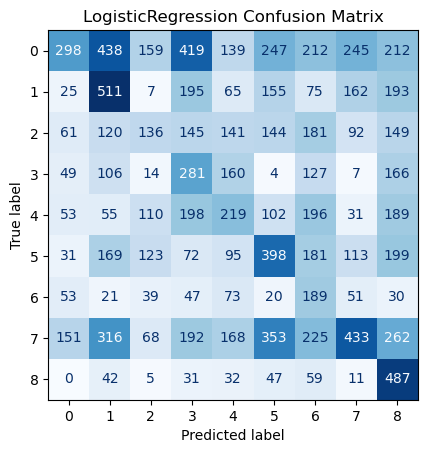

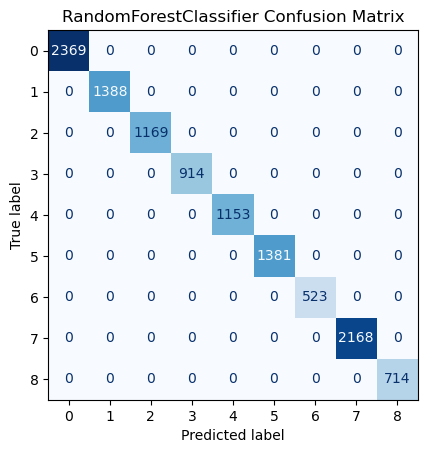

In [190]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Iterate through models
for name, model in default_models.items():
    y_val = base_model_results[name]['y_outputs']['y_val']
    y_val_pred = base_model_results[name]['y_outputs']['y_val_pred']

    # Calculate the confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.title(name+" Confusion Matrix")
    plt.grid(False)
    plt.show()

conclusion:
* logistic regression underfitting
* random forest overfitting

### Feature importance checks

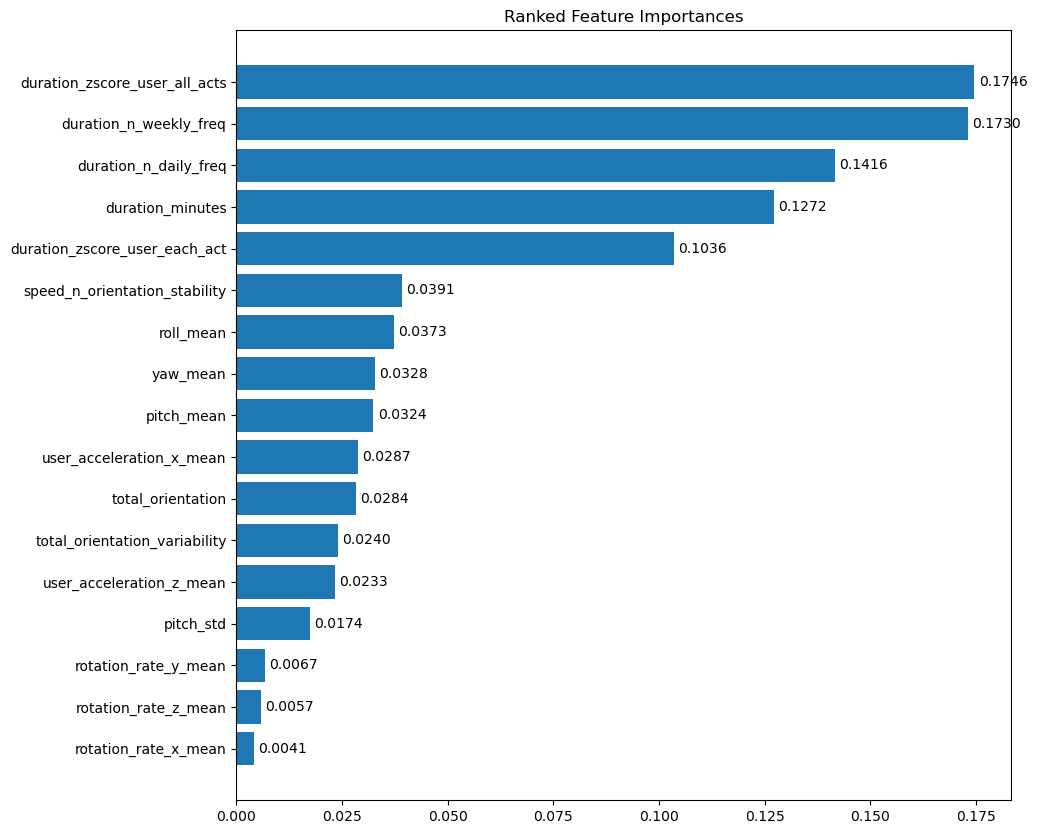

In [191]:
# Use Random Forest to extract feature importance
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=30, random_state=42))
    ])

# First, fit the pipeline
pipeline.fit(X_train, y_train)

# After fitting
rf = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf.feature_importances_

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,10))
bars = plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Ranked Feature Importances")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center')
plt.show()




## Hyperparameter tuning

In [192]:
''' Hyperparameters for Logistic Regression '''
# handles multiclass & larger datasets
lr_solver = ['saga']   
# Number of iterations    
lr_max_iter = [1000]        # increase iterations for convergence
# Regularization
lr_penalty = ['l2']
# inverse regularization strength
lr_C = [0.1, 1, 10]   
# Class weight            
lr_class_weight = ['balanced'] # handle class imbalance

# Combined
lr_hyperparameters = {
    'classifier__solver': lr_solver,
    'classifier__max_iter': lr_max_iter,
    'classifier__penalty': lr_penalty,
    'classifier__C': lr_C,
    'classifier__class_weight': lr_class_weight,
    'classifier__random_state': [42]
}

In [193]:
'''Hyperparameters for Random Forest Classifier'''

# Number of trees in random forest
rf_n_estimators = [100, 150]
# Number of features to consider at every split
rf_max_features = ['sqrt']
# Maximum number of levels in tree
rf_max_depth = [5, 10]
# Minimum number of samples required to split a node
rf_min_samples_split = [10, 20]
# Minimum number of samples required at each leaf node
rf_min_samples_leaf = [5, 7, 10]
# Method of selecting samples for training each tree
rf_bootstrap = [True]
# Handle imbalance
rf_class_weight = ['balanced'] # already did upsampling/downsampling earlier

# Combined
rf_hyperparameters = {
    'classifier__n_estimators': rf_n_estimators,
    'classifier__max_features': rf_max_features,
    'classifier__max_depth': rf_max_depth,
    'classifier__min_samples_split': rf_min_samples_split,
    'classifier__min_samples_leaf': rf_min_samples_leaf,
    'classifier__bootstrap': rf_bootstrap,
    'classifier__random_state': [42]
}

In [194]:
random_hyperparameter_grid = [
    # lr_hyperparameters,
    rf_hyperparameters
]

model_list = [
    # LogisticRegression(),
    RandomForestClassifier()
]

In [195]:
from sklearn.model_selection import KFold
cross_val_num = 3
cv = KFold(n_splits=cross_val_num, shuffle=True, random_state=42)
print(cv)

KFold(n_splits=3, random_state=42, shuffle=True)


In [196]:
# Estimate time taken for randomizedsearchcv

import time
from sklearn.model_selection import ParameterSampler

n_iter = 50
cv = cross_val_num
for model, param_grid in zip(model_list, random_hyperparameter_grid):
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter))

    # For time estimation, just take the last sample
    sample_params = param_list[-1]

    # Extract the model instance
    # model = sample_params['classifier']
    
    # Remove 'classifier' key so we can pass the rest to set_params
    pipeline_params = {k: v for k, v in sample_params.items() if k != 'classifier'}

    # Build pipeline
    base_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Apply hyperparameters
    base_pipeline.set_params(**pipeline_params)

    # Time the fit
    start = time.time()
    base_pipeline.fit(X_train, y_train)
    duration = time.time() - start

    # Estimate total
    estimated_total = duration * n_iter * cv
    print(f"{model.__class__.__name__}: Estimated total time: {estimated_total:.2f} seconds (~{estimated_total/60:.2f} minutes)")


c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForestClassifier: Estimated total time: 4940.29 seconds (~82.34 minutes)


### Randomized Search CV

In [197]:
from sklearn.model_selection import RandomizedSearchCV

randomsearch_best_models = {}

for model,param_grid in zip(model_list, random_hyperparameter_grid):
    name = type(model).__name__

    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])


    random_grid = RandomizedSearchCV(
            estimator=clf,
            param_distributions=param_grid,
            n_iter=n_iter,
            scoring='f1_macro',
            cv=cv,
            random_state=42,
            verbose=3,
            n_jobs=1 #  non-parallel processing
        )

    random_grid.fit(X_train, y_train)

    randomsearch_best_models[name] = {
        'best_params': random_grid.best_params_,
        'best_score': random_grid.best_score_,
        'best_estimator': random_grid.best_estimator_
    }

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100, classifier__random_state=42;, score=0.457 total time=  10.8s
[CV 2/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100, classifier__random_state=42;, score=0.439 total time=  10.4s
[CV 3/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100, classifier__random_state=42;, score=0.430 total time=  10.5s
[CV 1/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=150, classifier__random_state=42;, score=0.437 tot

In [198]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

randomsearchcv_model_results = {}

for model_name, model_data in randomsearch_best_models.items():
    best_pipeline = model_data['best_estimator']
    best_params = model_data['best_params']

    print(f"\nEvaluating train/val/test...")

    # Train
    y_train_pred = best_pipeline.predict(X_train)
    y_train_pred_proba = best_pipeline.predict_proba(X_train)
    train_scores = evaluate_classification(y_train, y_train_pred, y_train_pred_proba)

    # Validation
    y_val_pred = best_pipeline.predict(X_val)
    y_val_pred_proba = best_pipeline.predict_proba(X_val)
    val_scores = evaluate_classification(y_val, y_val_pred, y_val_pred_proba)

    print("\n=== Train Scores ===")
    print(train_scores)

    print("\n=== Validation Scores ===")
    print(val_scores)

    randomsearchcv_model_results[model_name] = {
        'y_outputs':
        {'y_val': y_val,
         'y_val_pred': y_val_pred,
         'y_val_pred_proba': y_val_pred_proba},
        'metrics': val_scores,
        'report': classification_report(y_val, y_val_pred)
    }
    print(f"\n=== {model_name} ===")
    pprint(best_params)
    print("\nMetrics:")
    pprint(randomsearchcv_model_results[model_name]['metrics'])
    print("\nClassification Report:", randomsearchcv_model_results[model_name]['report'])
    



Evaluating train/val/test...

=== Train Scores ===
{'accuracy': 0.9673373233159303, 'precision': 0.9718909772573728, 'recall': 0.9533266933247724, 'f1': 0.9612719658176595, 'roc_auc': 0.9994008523898784}

=== Validation Scores ===
{'accuracy': 0.9669751252228542, 'precision': 0.9718453004529652, 'recall': 0.9521411032113674, 'f1': 0.960637230097498, 'roc_auc': 0.9993737887176662}

=== RandomForestClassifier ===
{'classifier__bootstrap': True,
 'classifier__max_depth': 10,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 100,
 'classifier__random_state': 42}

Metrics:
{'accuracy': 0.9669751252228542,
 'f1': 0.960637230097498,
 'precision': 0.9718453004529652,
 'recall': 0.9521411032113674,
 'roc_auc': 0.9993737887176662}

Classification Report:                precision    recall  f1-score   support

       chores       0.95      1.00      0.98      2369
          eat       1.00      0.97      0.9

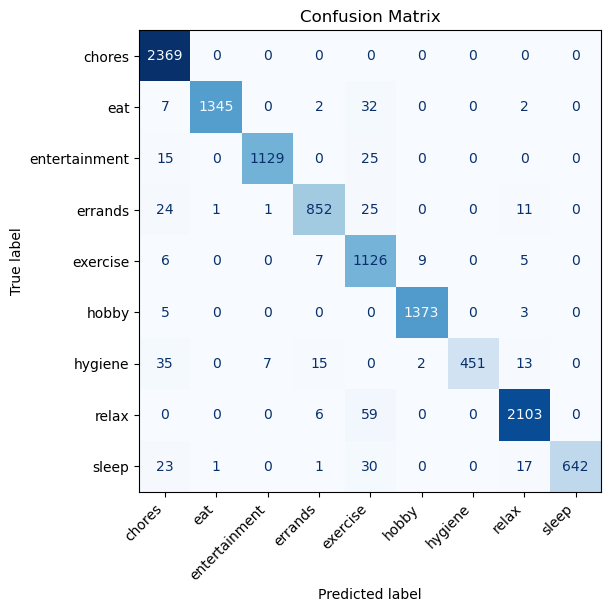

In [199]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in randomsearchcv_model_results.items():
    y_val = randomsearchcv_model_results[name]['y_outputs']['y_val']
    y_val_pred = randomsearchcv_model_results[name]['y_outputs']['y_val_pred']

    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_val,
        y_val_pred,
        display_labels=best_pipeline.classes_,
        cmap="Blues",
        ax=ax,          # plot on your existing figure
        colorbar=False
    )
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()



## Using same model, different features

In [216]:
# SAFE FEATURES: Only motion and acceleration sensors
safe_sensor_features = [
    # Basic motion features (orientation)
    'yaw_mean', 'pitch_mean', 'roll_mean', 
    'yaw_std', 'pitch_std', 'roll_std',
    
    # Rotation rate features
    'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean',
    'rotation_rate_x_std', 'rotation_rate_y_std', 'rotation_rate_z_std',
    
    # User acceleration (device movement)
    'user_acceleration_x_mean', 'user_acceleration_z_mean',  # removed y due to correlation
    'user_acceleration_x_std', 'user_acceleration_z_std',
    
    # Magnitude features (overall activity intensity)
    'rotation_magnitude_mean', 'acceleration_magnitude_mean',
    'rotation_magnitude_std', 'acceleration_magnitude_std'
]

# REMOVED FEATURES (potential data leakage):
removed_features = [
    # # Temporal features (highly correlated with activities)
    # 'time_of_day_radians', 'time_of_day_cos', 'time_of_day_sin',
    # 'hour', 'day_of_week', 'is_weekend', 'is_daytime',
    # 'day_of_week_sin', 'day_of_week_cos',
    
    # # Location features (activities tied to locations)
    # 'distance_from_home_mean', 'distance_from_home_std',
    # 'distance_from_home_latitude_mean', 'distance_from_home_latitude_std',
    # 'distance_from_home_longitude_mean', 'distance_from_home_longitude_std',
    # 'bearing_from_home_mode', 'bearing_from_home_std',
    # 'is_at_home', 'mobility_level',
    # 'distance_from_home_mean_bin_fixed',

    # # Duration features (activities tied to duration spent on each)
    # 'duration_minutes',
    # 'duration_zscore_user_all_acts',
    # 'duration_zscore_user_each_act',
    # 'duration_n_daily_freq',
    # 'duration_n_weekly_freq',
    
    # # Speed/course (location-derived)
    # 'speed_mean', 'speed_std', 'course_mode', 'course_std',
    
    # # # Engineered features that might leak info
    # # 'total_motion', 'motion_variability', 'activity_intensity'
]

# Check which safe features are available in our dataset
available_safe_features = [f for f in safe_sensor_features if f in df.columns]
print(f"Available safe sensor features: {len(available_safe_features)}")
for feat in available_safe_features:
    print(f" {feat}")

missing_features = [f for f in safe_sensor_features+removed_features if f not in df.columns]
if missing_features:
    print(f"\nMissing features: {len(missing_features)}")
    for feat in missing_features:
        print(f" {feat}")

available_features_to_remove = [f for f in removed_features if f in df.columns]
print(f"\nRemoving {len(available_features_to_remove)} potentially leaky features:")
for feat in available_features_to_remove: #[:10]:  # Show first 10
    print(f"  ✗ {feat}")
# if len(removed_features) > 10:
#     print(f"  ... and {len(removed_features)-10} more")

missed_out_features = [f for f in df.columns if f not in safe_sensor_features+removed_features]
print(f"\nFeatures to keep for now: {len(missed_out_features)}")
if missed_out_features:
    for feat in missed_out_features:
        print(f"  ? {feat}")

# Create clean feature dataset
feature_df_clean_2 = df[available_safe_features + missed_out_features].copy()
print(f"\nClean dataset shape: {feature_df_clean_2.shape}")
print(f"Features for modeling: {len(available_safe_features)+len(missed_out_features)}")
print(feature_df_clean_2.info())

Available safe sensor features: 9
 yaw_mean
 pitch_mean
 roll_mean
 pitch_std
 rotation_rate_x_mean
 rotation_rate_y_mean
 rotation_rate_z_mean
 user_acceleration_x_mean
 user_acceleration_z_mean

Missing features: 11
 yaw_std
 roll_std
 rotation_rate_x_std
 rotation_rate_y_std
 rotation_rate_z_std
 user_acceleration_x_std
 user_acceleration_z_std
 rotation_magnitude_mean
 acceleration_magnitude_mean
 rotation_magnitude_std
 acceleration_magnitude_std

Removing 0 potentially leaky features:

Features to keep for now: 23
  ? speed_mean
  ? speed_std
  ? course_mode
  ? course_std
  ? distance_from_home_latitude_mean
  ? distance_from_home_longitude_mean
  ? bearing_from_home_mode
  ? bearing_from_home_std
  ? time_of_day_sin
  ? time_of_day_cos
  ? day_of_week
  ? activity_label
  ? duration_minutes
  ? day_of_week_sin
  ? day_of_week_cos
  ? duration_zscore_user_all_acts
  ? duration_zscore_user_each_act
  ? total_orientation_variability
  ? total_orientation
  ? speed_n_orientation_st

### Pipeline creation

In [222]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# Nominal features to be one-hot encoded
# If activity labels are limited: ['Eat' 'Climbing stairs' 'Fall' 'Run' 'Other exercise' 'Sleep' 'Sitting down' 'Walk']
nominal_cols_encode = ['distance_from_home_mean_bin_fixed']

# Numerical features to be imputed and scaled
numerical_cols_scale = feature_df_clean_2.select_dtypes(include='number').columns.tolist()

# nominal_onehot_pipe = Pipeline([
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

numerical_scale_pipe = Pipeline([ # to add skew correction
    ('scaler', StandardScaler())
])

print(numerical_cols_scale)
print(len(nominal_cols_encode)+len(numerical_cols_scale))  # 

['yaw_mean', 'pitch_mean', 'roll_mean', 'pitch_std', 'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean', 'user_acceleration_x_mean', 'user_acceleration_z_mean', 'speed_mean', 'speed_std', 'course_mode', 'course_std', 'distance_from_home_latitude_mean', 'distance_from_home_longitude_mean', 'bearing_from_home_mode', 'bearing_from_home_std', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week', 'duration_minutes', 'day_of_week_sin', 'day_of_week_cos', 'duration_zscore_user_all_acts', 'duration_zscore_user_each_act', 'total_orientation_variability', 'total_orientation', 'speed_n_orientation_stability', 'duration_n_daily_freq', 'duration_n_weekly_freq']
31


In [223]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal_encode', nominal_onehot_pipe, nominal_cols_encode),
        ('num_scale', numerical_scale_pipe, numerical_cols_scale)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1
    )


### Baseline models

In [224]:
# Separate the data into features and target
X = feature_df_clean_2.drop(columns='activity_label')
y = feature_df_clean_2['activity_label']

# Split the data into training and test sets, ensuring stratification
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split the test-validation set (20%) into validation (10%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42, stratify=y_testval)


In [225]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
def evaluate_classification(y_target, y_prediction, y_prediction_proba) -> list:
    scores = {}
    scores['accuracy']  = accuracy_score(y_target, y_prediction)
    scores['precision'] = precision_score(y_target, y_prediction, average='macro')
    scores['recall']    = recall_score(y_target, y_prediction, average='macro')
    scores['f1']        = f1_score(y_target, y_prediction, average='macro')
    
    scores['roc_auc'] = None
    if y_prediction_proba is not None:
        try:
            scores['roc_auc'] = roc_auc_score(
                y_target, y_prediction_proba, multi_class='ovr', average='macro'
            )
        except ValueError:
            pass
    
    return scores

In [226]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

default_models = {
    'LogisticRegression' : LogisticRegression(class_weight='balanced', multi_class='multinomial'),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42)
}

# Store results
base_model_results = {}
# Store base pipeline
base_pipelines = {}
# Store base metrics
# base_metrics = {}

# Iterate through models
for name, model in default_models.items():

    base_pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', model)
    ])
    
    # Fit on training data
    base_pipeline.fit(X_train, y_train)

    # add pipeline for current model into pipelines dictionary
    base_pipelines[name] = base_pipeline

    # Predict on validation set
    y_val_pred = base_pipeline.predict(X_val)
    y_pred_proba = base_pipeline.predict_proba(X_val)
    
    # Compute metrics
    metrics = evaluate_classification(y_val, y_val_pred, y_pred_proba)
    
    # Store and print results
    base_model_results[name] = {
        'y_outputs':
        {'y_val': y_val,
         'y_val_pred': y_val_pred,
         'y_pred_proba': y_pred_proba},
        'metrics': metrics,
        'report': classification_report(y_val, y_val_pred)
    }
    print(f"\n=== {name} ===")
    print("Metrics:\n")
    pprint(base_model_results[name]['metrics'])
    print("Classification Report:\n", base_model_results[name]['report'])



c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== LogisticRegression ===
Metrics:

{'accuracy': 0.3900161304015621,
 'f1': 0.38829443770382177,
 'precision': 0.38815010360922647,
 'recall': 0.4344132297678457,
 'roc_auc': 0.8186957069365505}
Classification Report:
                precision    recall  f1-score   support

       chores       0.56      0.26      0.36      2369
          eat       0.41      0.41      0.41      1388
entertainment       0.40      0.44      0.42      1169
      errands       0.31      0.46      0.37       914
     exercise       0.28      0.27      0.27      1153
        hobby       0.40      0.42      0.41      1381
      hygiene       0.26      0.55      0.35       523
        relax       0.52      0.34      0.41      2168
        sleep       0.35      0.73      0.47       714

     accuracy                           0.39     11779
    macro avg       0.39      0.43      0.39     11779
 weighted avg       0.43      0.39      0.39     11779


=== RandomForestClassifier ===
Metrics:

{'accuracy': 1.0, '

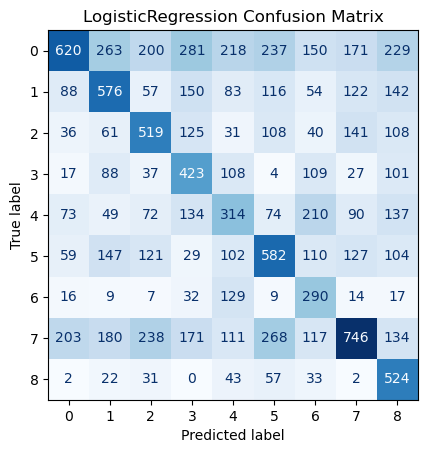

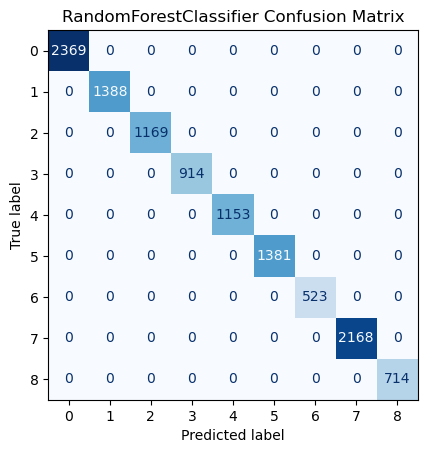

In [227]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Iterate through models
for name, model in default_models.items():
    y_val = base_model_results[name]['y_outputs']['y_val']
    y_val_pred = base_model_results[name]['y_outputs']['y_val_pred']

    # Calculate the confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.title(name+" Confusion Matrix")
    plt.grid(False)
    plt.show()

conclusion:
* logistic regression underfitting
* random forest overfitting

### Feature importance checks

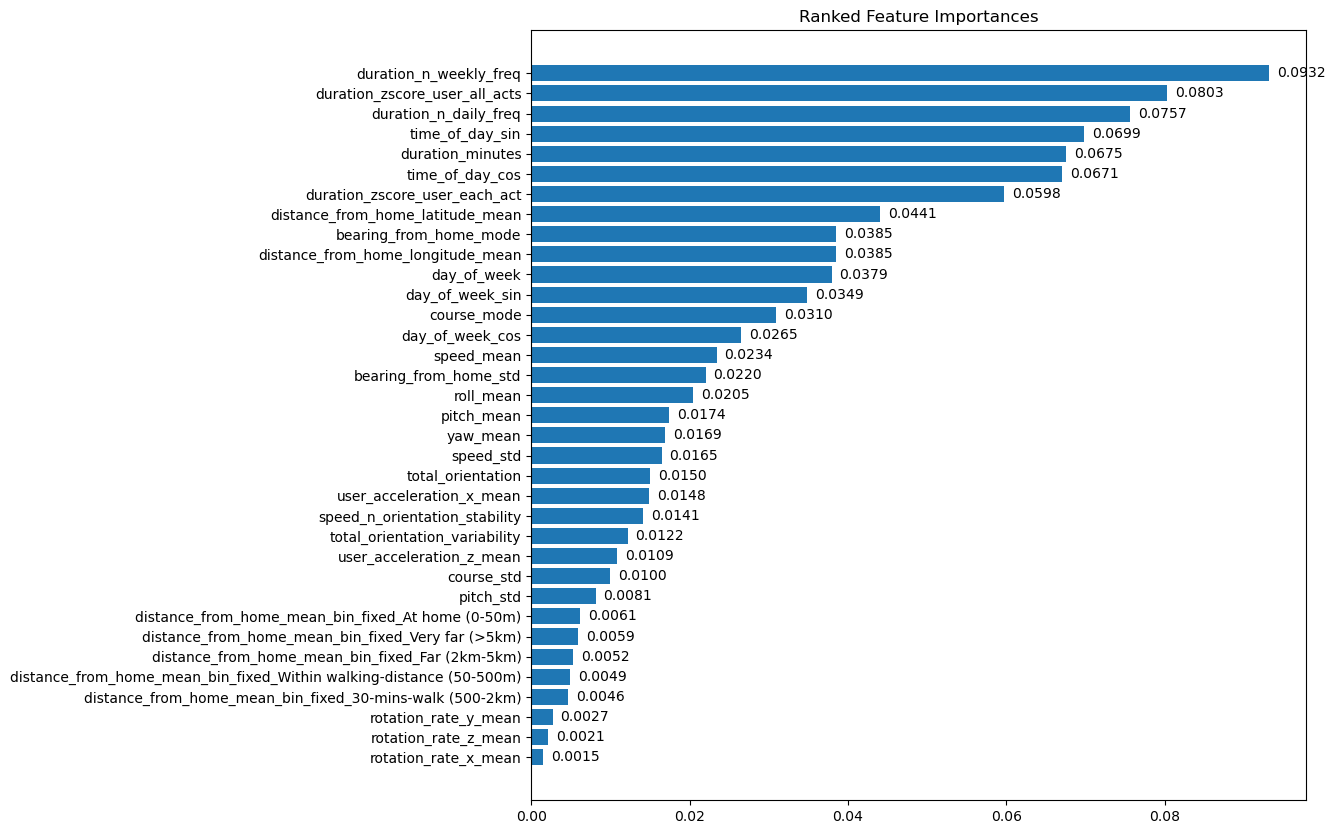

In [228]:
# Use Random Forest to extract feature importance
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=30, random_state=42))
    ])

# First, fit the pipeline
pipeline.fit(X_train, y_train)

# After fitting
rf = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf.feature_importances_

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,10))
bars = plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Ranked Feature Importances")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center')
plt.show()




## Hyperparameter tuning

In [229]:
''' Hyperparameters for Logistic Regression '''
# handles multiclass & larger datasets
lr_solver = ['saga']   
# Number of iterations    
lr_max_iter = [1000]        # increase iterations for convergence
# Regularization
lr_penalty = ['l2']
# inverse regularization strength
lr_C = [0.1, 1, 10]   
# Class weight            
lr_class_weight = ['balanced'] # handle class imbalance

# Combined
lr_hyperparameters = {
    'classifier__solver': lr_solver,
    'classifier__max_iter': lr_max_iter,
    'classifier__penalty': lr_penalty,
    'classifier__C': lr_C,
    'classifier__class_weight': lr_class_weight,
    'classifier__random_state': [42]
}

In [230]:
'''Hyperparameters for Random Forest Classifier'''

# Number of trees in random forest
rf_n_estimators = [100, 150]
# Number of features to consider at every split
rf_max_features = ['sqrt']
# Maximum number of levels in tree
rf_max_depth = [5, 10]
# Minimum number of samples required to split a node
rf_min_samples_split = [10, 20]
# Minimum number of samples required at each leaf node
rf_min_samples_leaf = [5, 7, 10]
# Method of selecting samples for training each tree
rf_bootstrap = [True]
# Handle imbalance
rf_class_weight = ['balanced'] # already did upsampling/downsampling earlier

# Combined
rf_hyperparameters = {
    'classifier__n_estimators': rf_n_estimators,
    'classifier__max_features': rf_max_features,
    'classifier__max_depth': rf_max_depth,
    'classifier__min_samples_split': rf_min_samples_split,
    'classifier__min_samples_leaf': rf_min_samples_leaf,
    'classifier__bootstrap': rf_bootstrap,
    'classifier__random_state': [42]
}

In [231]:
random_hyperparameter_grid = [
    # lr_hyperparameters,
    rf_hyperparameters
]

model_list = [
    # LogisticRegression(),
    RandomForestClassifier()
]

In [232]:
from sklearn.model_selection import KFold
cross_val_num = 3
cv = KFold(n_splits=cross_val_num, shuffle=True, random_state=42)
print(cv)

KFold(n_splits=3, random_state=42, shuffle=True)


In [233]:
# Estimate time taken for randomizedsearchcv

import time
from sklearn.model_selection import ParameterSampler

n_iter = 50
cv = cross_val_num
for model, param_grid in zip(model_list, random_hyperparameter_grid):
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter))

    # For time estimation, just take the last sample
    sample_params = param_list[-1]

    # Extract the model instance
    # model = sample_params['classifier']
    
    # Remove 'classifier' key so we can pass the rest to set_params
    pipeline_params = {k: v for k, v in sample_params.items() if k != 'classifier'}

    # Build pipeline
    base_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Apply hyperparameters
    base_pipeline.set_params(**pipeline_params)

    # Time the fit
    start = time.time()
    base_pipeline.fit(X_train, y_train)
    duration = time.time() - start

    # Estimate total
    estimated_total = duration * n_iter * cv
    print(f"{model.__class__.__name__}: Estimated total time: {estimated_total:.2f} seconds (~{estimated_total/60:.2f} minutes)")


c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForestClassifier: Estimated total time: 5818.76 seconds (~96.98 minutes)


### Randomized Search CV

In [234]:
from sklearn.model_selection import RandomizedSearchCV

randomsearch_best_models = {}

for model,param_grid in zip(model_list, random_hyperparameter_grid):
    name = type(model).__name__

    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])


    random_grid = RandomizedSearchCV(
            estimator=clf,
            param_distributions=param_grid,
            n_iter=n_iter,
            scoring='f1_macro',
            cv=cv,
            random_state=42,
            verbose=3,
            n_jobs=1 #  non-parallel processing
        )

    random_grid.fit(X_train, y_train)

    randomsearch_best_models[name] = {
        'best_params': random_grid.best_params_,
        'best_score': random_grid.best_score_,
        'best_estimator': random_grid.best_estimator_
    }

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100, classifier__random_state=42;, score=0.551 total time=  10.8s
[CV 2/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100, classifier__random_state=42;, score=0.555 total time=  10.3s
[CV 3/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100, classifier__random_state=42;, score=0.552 total time=   8.7s
[CV 1/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=150, classifier__random_state=42;, score=0.592 tot

In [235]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

randomsearchcv_model_results = {}

for model_name, model_data in randomsearch_best_models.items():
    best_pipeline = model_data['best_estimator']
    best_params = model_data['best_params']

    print(f"\nEvaluating train/val/test...")

    # Train
    y_train_pred = best_pipeline.predict(X_train)
    y_train_pred_proba = best_pipeline.predict_proba(X_train)
    train_scores = evaluate_classification(y_train, y_train_pred, y_train_pred_proba)

    # Validation
    y_val_pred = best_pipeline.predict(X_val)
    y_val_pred_proba = best_pipeline.predict_proba(X_val)
    val_scores = evaluate_classification(y_val, y_val_pred, y_val_pred_proba)

    print("\n=== Train Scores ===")
    print(train_scores)

    print("\n=== Validation Scores ===")
    print(val_scores)

    randomsearchcv_model_results[model_name] = {
        'y_outputs':
        {'y_val': y_val,
         'y_val_pred': y_val_pred,
         'y_val_pred_proba': y_val_pred_proba},
        'metrics': val_scores,
        'report': classification_report(y_val, y_val_pred)
    }
    print(f"\n=== {model_name} ===")
    pprint(best_params)
    print("\nMetrics:")
    pprint(randomsearchcv_model_results[model_name]['metrics'])
    print("\nClassification Report:", randomsearchcv_model_results[model_name]['report'])
    



Evaluating train/val/test...

=== Train Scores ===
{'accuracy': 0.9972091345133495, 'precision': 0.9978884217971109, 'recall': 0.9956955292704117, 'f1': 0.9967783014239324, 'roc_auc': 0.9999862823536745}

=== Validation Scores ===
{'accuracy': 0.9971984039392139, 'precision': 0.9978283493921194, 'recall': 0.9955737341607005, 'f1': 0.9966817835702909, 'roc_auc': 0.9999767899760664}

=== RandomForestClassifier ===
{'classifier__bootstrap': True,
 'classifier__max_depth': 10,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 20,
 'classifier__n_estimators': 100,
 'classifier__random_state': 42}

Metrics:
{'accuracy': 0.9971984039392139,
 'f1': 0.9966817835702909,
 'precision': 0.9978283493921194,
 'recall': 0.9955737341607005,
 'roc_auc': 0.9999767899760664}

Classification Report:                precision    recall  f1-score   support

       chores       1.00      1.00      1.00      2369
          eat       1.00      1.00      1

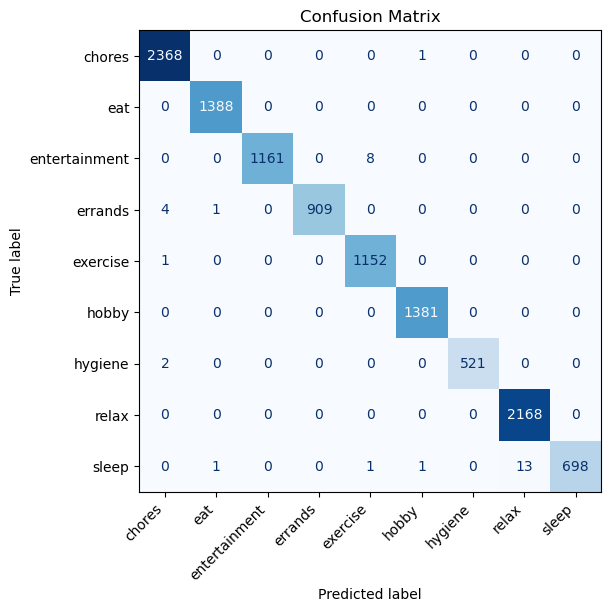

In [236]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in randomsearchcv_model_results.items():
    y_val = randomsearchcv_model_results[name]['y_outputs']['y_val']
    y_val_pred = randomsearchcv_model_results[name]['y_outputs']['y_val_pred']

    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_val,
        y_val_pred,
        display_labels=best_pipeline.classes_,
        cmap="Blues",
        ax=ax,          # plot on your existing figure
        colorbar=False
    )
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()



## Last try with only sensor features

In [239]:
# SAFE FEATURES: Only motion and acceleration sensors
safe_sensor_features = [
    # Basic motion features (orientation)
    'yaw_mean', 'pitch_mean', 'roll_mean', 
    'yaw_std', 'pitch_std', 'roll_std',
    
    # Rotation rate features
    'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean',
    'rotation_rate_x_std', 'rotation_rate_y_std', 'rotation_rate_z_std',
    
    # User acceleration (device movement)
    'user_acceleration_x_mean', 'user_acceleration_z_mean',  # removed y due to correlation
    'user_acceleration_x_std', 'user_acceleration_z_std',
    
    # Magnitude features (overall activity intensity)
    'rotation_magnitude_mean', 'acceleration_magnitude_mean',
    'rotation_magnitude_std', 'acceleration_magnitude_std'
]

# REMOVED FEATURES (potential data leakage):
removed_features = [
    # Temporal features (highly correlated with activities)
    'time_of_day_radians', 'time_of_day_cos', 'time_of_day_sin',
    'hour', 'day_of_week', 'is_weekend', 'is_daytime',
    'day_of_week_sin', 'day_of_week_cos',
    
    # Location features (activities tied to locations)
    'distance_from_home_mean', 'distance_from_home_std',
    'distance_from_home_latitude_mean', 'distance_from_home_latitude_std',
    'distance_from_home_longitude_mean', 'distance_from_home_longitude_std',
    'bearing_from_home_mode', 'bearing_from_home_std',
    'is_at_home', 'mobility_level',
    'distance_from_home_mean_bin_fixed',

    # Duration features (activities tied to duration spent on each)
    'duration_minutes',
    'duration_zscore_user_all_acts',
    'duration_zscore_user_each_act',
    'duration_n_daily_freq',
    'duration_n_weekly_freq',
    
    # Speed/course (location-derived)
    'speed_mean', 'speed_std', 'course_mode', 'course_std',
    
    # Engineered features that might leak info
    'total_motion', 'motion_variability', 'activity_intensity'
]

# Check which safe features are available in our dataset
available_safe_features = [f for f in safe_sensor_features if f in df.columns]
print(f"Available safe sensor features: {len(available_safe_features)}")
for feat in available_safe_features:
    print(f" {feat}")

missing_features = [f for f in safe_sensor_features+removed_features if f not in df.columns]
if missing_features:
    print(f"\nMissing features: {len(missing_features)}")
    for feat in missing_features:
        print(f" {feat}")

available_features_to_remove = [f for f in removed_features if f in df.columns]
print(f"\nRemoving {len(available_features_to_remove)} potentially leaky features:")
for feat in available_features_to_remove: #[:10]:  # Show first 10
    print(f"  ✗ {feat}")
# if len(removed_features) > 10:
#     print(f"  ... and {len(removed_features)-10} more")

missed_out_features = [f for f in df.columns if f not in safe_sensor_features+removed_features]
print(f"\nFeatures to keep for now: {len(missed_out_features)}")
if missed_out_features:
    for feat in missed_out_features:
        print(f"  ? {feat}")

# Create clean feature dataset
feature_df_clean_3 = df[available_safe_features + missed_out_features].copy()
print(f"\nClean dataset shape: {feature_df_clean_3.shape}")
print(f"Features for modeling: {len(available_safe_features)+len(missed_out_features)}")
print(feature_df_clean_3.info())

Available safe sensor features: 9
 yaw_mean
 pitch_mean
 roll_mean
 pitch_std
 rotation_rate_x_mean
 rotation_rate_y_mean
 rotation_rate_z_mean
 user_acceleration_x_mean
 user_acceleration_z_mean

Missing features: 24
 yaw_std
 roll_std
 rotation_rate_x_std
 rotation_rate_y_std
 rotation_rate_z_std
 user_acceleration_x_std
 user_acceleration_z_std
 rotation_magnitude_mean
 acceleration_magnitude_mean
 rotation_magnitude_std
 acceleration_magnitude_std
 time_of_day_radians
 hour
 is_weekend
 is_daytime
 distance_from_home_mean
 distance_from_home_std
 distance_from_home_latitude_std
 distance_from_home_longitude_std
 is_at_home
 mobility_level
 total_motion
 motion_variability
 activity_intensity

Removing 19 potentially leaky features:
  ✗ time_of_day_cos
  ✗ time_of_day_sin
  ✗ day_of_week
  ✗ day_of_week_sin
  ✗ day_of_week_cos
  ✗ distance_from_home_latitude_mean
  ✗ distance_from_home_longitude_mean
  ✗ bearing_from_home_mode
  ✗ bearing_from_home_std
  ✗ distance_from_home_mean_bi

### Pipeline creation

In [240]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# Nominal features to be one-hot encoded
# If activity labels are limited: ['Eat' 'Climbing stairs' 'Fall' 'Run' 'Other exercise' 'Sleep' 'Sitting down' 'Walk']
# nominal_cols_encode = ['distance_from_home_mean_bin_fixed']

# Numerical features to be imputed and scaled
numerical_cols_scale = feature_df_clean_3.select_dtypes(include='number').columns.tolist()

# nominal_onehot_pipe = Pipeline([
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

numerical_scale_pipe = Pipeline([ # to add skew correction
    ('scaler', StandardScaler())
])

print(numerical_cols_scale)
print(len(numerical_cols_scale))  # len(nominal_cols_encode)+

['yaw_mean', 'pitch_mean', 'roll_mean', 'pitch_std', 'rotation_rate_x_mean', 'rotation_rate_y_mean', 'rotation_rate_z_mean', 'user_acceleration_x_mean', 'user_acceleration_z_mean', 'total_orientation_variability', 'total_orientation', 'speed_n_orientation_stability']
12


In [241]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        # ('nominal_encode', nominal_onehot_pipe, nominal_cols_encode),
        ('num_scale', numerical_scale_pipe, numerical_cols_scale)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    n_jobs=-1
    )


### Baseline models

In [242]:
# Separate the data into features and target
X = feature_df_clean.drop(columns='activity_label')
y = feature_df_clean['activity_label']

# Split the data into training and test sets, ensuring stratification
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split the test-validation set (20%) into validation (10%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42, stratify=y_testval)


In [243]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
def evaluate_classification(y_target, y_prediction, y_prediction_proba) -> list:
    scores = {}
    scores['accuracy']  = accuracy_score(y_target, y_prediction)
    scores['precision'] = precision_score(y_target, y_prediction, average='macro')
    scores['recall']    = recall_score(y_target, y_prediction, average='macro')
    scores['f1']        = f1_score(y_target, y_prediction, average='macro')
    
    scores['roc_auc'] = None
    if y_prediction_proba is not None:
        try:
            scores['roc_auc'] = roc_auc_score(
                y_target, y_prediction_proba, multi_class='ovr', average='macro'
            )
        except ValueError:
            pass
    
    return scores

In [244]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

default_models = {
    'LogisticRegression' : LogisticRegression(class_weight='balanced', multi_class='multinomial'),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42)
}

# Store results
base_model_results = {}
# Store base pipeline
base_pipelines = {}
# Store base metrics
# base_metrics = {}

# Iterate through models
for name, model in default_models.items():

    base_pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', model)
    ])
    
    # Fit on training data
    base_pipeline.fit(X_train, y_train)

    # add pipeline for current model into pipelines dictionary
    base_pipelines[name] = base_pipeline

    # Predict on validation set
    y_val_pred = base_pipeline.predict(X_val)
    y_pred_proba = base_pipeline.predict_proba(X_val)
    
    # Compute metrics
    metrics = evaluate_classification(y_val, y_val_pred, y_pred_proba)
    
    # Store and print results
    base_model_results[name] = {
        'y_outputs':
        {'y_val': y_val,
         'y_val_pred': y_val_pred,
         'y_pred_proba': y_pred_proba},
        'metrics': metrics,
        'report': classification_report(y_val, y_val_pred)
    }
    print(f"\n=== {name} ===")
    print("Metrics:\n")
    pprint(base_model_results[name]['metrics'])
    print("Classification Report:\n", base_model_results[name]['report'])



c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogisticRegression ===
Metrics:

{'accuracy': 0.1758213770269123,
 'f1': 0.1623259168201332,
 'precision': 0.17424070757159288,
 'recall': 0.22743279374902858,
 'roc_auc': 0.6437510702170612}
Classification Report:
                precision    recall  f1-score   support

       chores       0.33      0.19      0.25      2369
          eat       0.09      0.04      0.06      1388
entertainment       0.15      0.12      0.13      1169
      errands       0.20      0.20      0.20       914
     exercise       0.19      0.09      0.12      1153
        hobby       0.19      0.27      0.22      1381
      hygiene       0.11      0.45      0.17       523
        relax       0.14      0.03      0.04      2168
        sleep       0.17      0.66      0.27       714

     accuracy                           0.18     11779
    macro avg       0.17      0.23      0.16     11779
 weighted avg       0.19      0.18      0.15     11779


=== RandomForestClassifier ===
Metrics:

{'accuracy': 0.9991

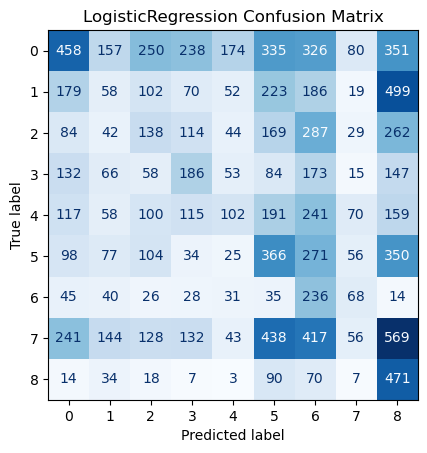

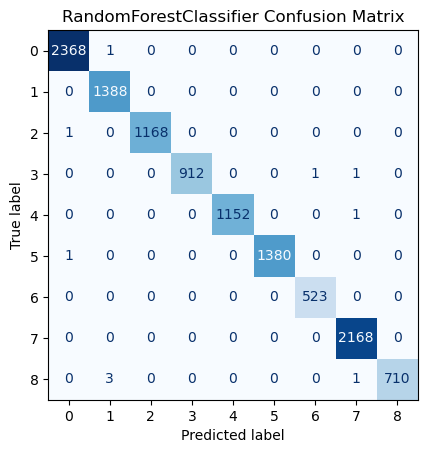

In [245]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Iterate through models
for name, model in default_models.items():
    y_val = base_model_results[name]['y_outputs']['y_val']
    y_val_pred = base_model_results[name]['y_outputs']['y_val_pred']

    # Calculate the confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.title(name+" Confusion Matrix")
    plt.grid(False)
    plt.show()

conclusion:
* logistic regression underfitting
* random forest overfitting

### Feature importance checks

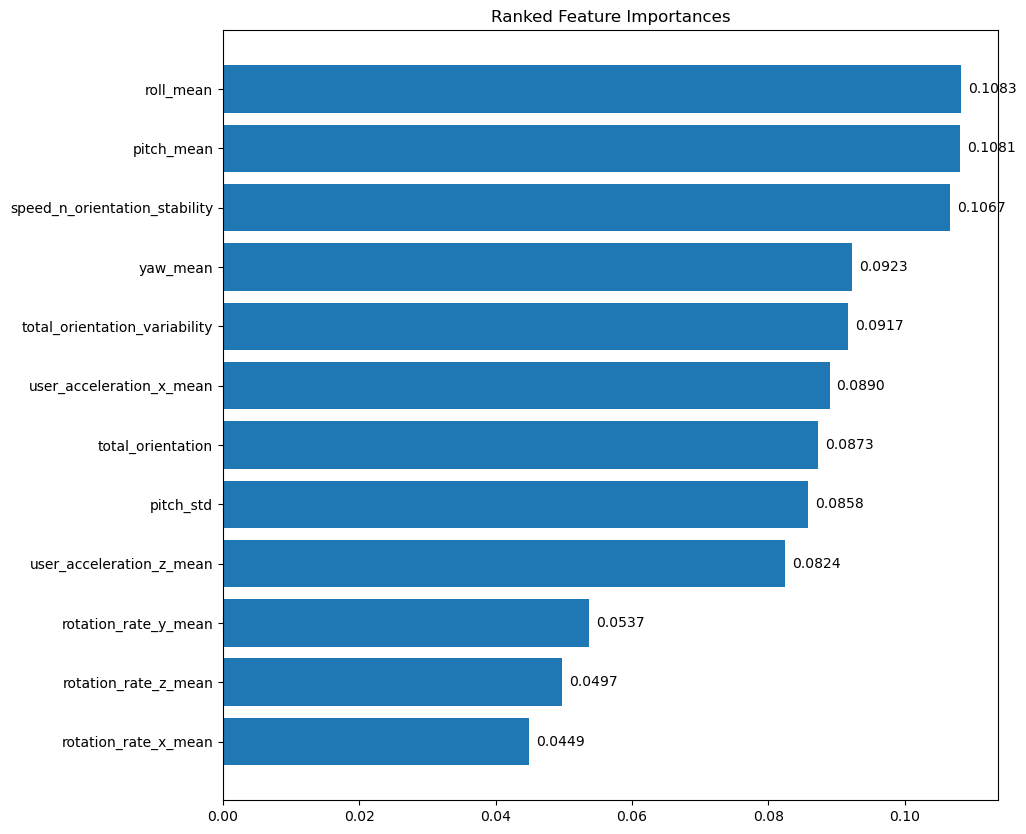

In [246]:
# Use Random Forest to extract feature importance
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=30, random_state=42))
    ])

# First, fit the pipeline
pipeline.fit(X_train, y_train)

# After fitting
rf = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf.feature_importances_

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,10))
bars = plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Ranked Feature Importances")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center')
plt.show()




## Hyperparameter tuning

In [247]:
''' Hyperparameters for Logistic Regression '''
# handles multiclass & larger datasets
lr_solver = ['saga']   
# Number of iterations    
lr_max_iter = [1000]        # increase iterations for convergence
# Regularization
lr_penalty = ['l2']
# inverse regularization strength
lr_C = [0.1, 1, 10]   
# Class weight            
lr_class_weight = ['balanced'] # handle class imbalance

# Combined
lr_hyperparameters = {
    'classifier__solver': lr_solver,
    'classifier__max_iter': lr_max_iter,
    'classifier__penalty': lr_penalty,
    'classifier__C': lr_C,
    'classifier__class_weight': lr_class_weight,
    'classifier__random_state': [42]
}

In [248]:
'''Hyperparameters for Random Forest Classifier'''

# Number of trees in random forest
rf_n_estimators = [100, 150]
# Number of features to consider at every split
rf_max_features = ['sqrt']
# Maximum number of levels in tree
rf_max_depth = [5, 10]
# Minimum number of samples required to split a node
rf_min_samples_split = [10, 20]
# Minimum number of samples required at each leaf node
rf_min_samples_leaf = [5, 7, 10]
# Method of selecting samples for training each tree
rf_bootstrap = [True]
# Handle imbalance
rf_class_weight = ['balanced'] # already did upsampling/downsampling earlier

# Combined
rf_hyperparameters = {
    'classifier__n_estimators': rf_n_estimators,
    'classifier__max_features': rf_max_features,
    'classifier__max_depth': rf_max_depth,
    'classifier__min_samples_split': rf_min_samples_split,
    'classifier__min_samples_leaf': rf_min_samples_leaf,
    'classifier__bootstrap': rf_bootstrap,
    'classifier__random_state': [42]
}

In [249]:
random_hyperparameter_grid = [
    # lr_hyperparameters,
    rf_hyperparameters
]

model_list = [
    # LogisticRegression(),
    RandomForestClassifier()
]

In [250]:
from sklearn.model_selection import KFold
cross_val_num = 3
cv = KFold(n_splits=cross_val_num, shuffle=True, random_state=42)
print(cv)

KFold(n_splits=3, random_state=42, shuffle=True)


In [251]:
# Estimate time taken for randomizedsearchcv

import time
from sklearn.model_selection import ParameterSampler

n_iter = 50
cv = cross_val_num
for model, param_grid in zip(model_list, random_hyperparameter_grid):
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter))

    # For time estimation, just take the last sample
    sample_params = param_list[-1]

    # Extract the model instance
    # model = sample_params['classifier']
    
    # Remove 'classifier' key so we can pass the rest to set_params
    pipeline_params = {k: v for k, v in sample_params.items() if k != 'classifier'}

    # Build pipeline
    base_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Apply hyperparameters
    base_pipeline.set_params(**pipeline_params)

    # Time the fit
    start = time.time()
    base_pipeline.fit(X_train, y_train)
    duration = time.time() - start

    # Estimate total
    estimated_total = duration * n_iter * cv
    print(f"{model.__class__.__name__}: Estimated total time: {estimated_total:.2f} seconds (~{estimated_total/60:.2f} minutes)")


c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForestClassifier: Estimated total time: 5982.33 seconds (~99.71 minutes)


### Randomized Search CV

In [252]:
from sklearn.model_selection import RandomizedSearchCV

randomsearch_best_models = {}

for model,param_grid in zip(model_list, random_hyperparameter_grid):
    name = type(model).__name__

    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])


    random_grid = RandomizedSearchCV(
            estimator=clf,
            param_distributions=param_grid,
            n_iter=n_iter,
            scoring='f1_macro',
            cv=cv,
            random_state=42,
            verbose=3,
            n_jobs=1 #  non-parallel processing
        )

    random_grid.fit(X_train, y_train)

    randomsearch_best_models[name] = {
        'best_params': random_grid.best_params_,
        'best_score': random_grid.best_score_,
        'best_estimator': random_grid.best_estimator_
    }

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\sugar\.conda\envs\iti113\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100, classifier__random_state=42;, score=0.271 total time=   9.4s
[CV 2/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100, classifier__random_state=42;, score=0.271 total time=   9.0s
[CV 3/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=100, classifier__random_state=42;, score=0.269 total time=   8.8s
[CV 1/3] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=150, classifier__random_state=42;, score=0.268 tot

In [253]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

randomsearchcv_model_results = {}

for model_name, model_data in randomsearch_best_models.items():
    best_pipeline = model_data['best_estimator']
    best_params = model_data['best_params']

    print(f"\nEvaluating train/val/test...")

    # Train
    y_train_pred = best_pipeline.predict(X_train)
    y_train_pred_proba = best_pipeline.predict_proba(X_train)
    train_scores = evaluate_classification(y_train, y_train_pred, y_train_pred_proba)

    # Validation
    y_val_pred = best_pipeline.predict(X_val)
    y_val_pred_proba = best_pipeline.predict_proba(X_val)
    val_scores = evaluate_classification(y_val, y_val_pred, y_val_pred_proba)

    print("\n=== Train Scores ===")
    print(train_scores)

    print("\n=== Validation Scores ===")
    print(val_scores)

    randomsearchcv_model_results[model_name] = {
        'y_outputs':
        {'y_val': y_val,
         'y_val_pred': y_val_pred,
         'y_val_pred_proba': y_val_pred_proba},
        'metrics': val_scores,
        'report': classification_report(y_val, y_val_pred)
    }
    print(f"\n=== {model_name} ===")
    pprint(best_params)
    print("\nMetrics:")
    pprint(randomsearchcv_model_results[model_name]['metrics'])
    print("\nClassification Report:", randomsearchcv_model_results[model_name]['report'])
    



Evaluating train/val/test...

=== Train Scores ===
{'accuracy': 0.6433528587800841, 'precision': 0.8123965637209062, 'recall': 0.5925567577416936, 'f1': 0.6499083174011164, 'roc_auc': 0.9420797480286889}

=== Validation Scores ===
{'accuracy': 0.6408863231174123, 'precision': 0.802919846497153, 'recall': 0.5917136313449218, 'f1': 0.6468184367540032, 'roc_auc': 0.9386386107441326}

=== RandomForestClassifier ===
{'classifier__bootstrap': True,
 'classifier__max_depth': 10,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 100,
 'classifier__random_state': 42}

Metrics:
{'accuracy': 0.6408863231174123,
 'f1': 0.6468184367540032,
 'precision': 0.802919846497153,
 'recall': 0.5917136313449218,
 'roc_auc': 0.9386386107441326}

Classification Report:                precision    recall  f1-score   support

       chores       0.52      0.85      0.64      2369
          eat       0.67      0.57      0.6

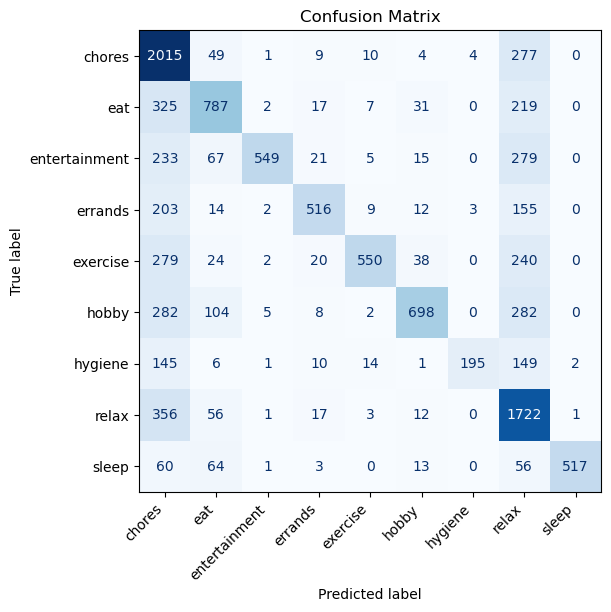

In [254]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in randomsearchcv_model_results.items():
    y_val = randomsearchcv_model_results[name]['y_outputs']['y_val']
    y_val_pred = randomsearchcv_model_results[name]['y_outputs']['y_val_pred']

    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_val,
        y_val_pred,
        display_labels=best_pipeline.classes_,
        cmap="Blues",
        ax=ax,          # plot on your existing figure
        colorbar=False
    )
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()



## Final

In [237]:
for model_name, model_data in randomsearch_best_models.items():
    best_pipeline = model_data['best_estimator']
    best_params = model_data['best_params']

    print(f"\nEvaluating train/val/test...")

    # Train
    y_test_pred = best_pipeline.predict(X_test)
    y_test_pred_proba = best_pipeline.predict_proba(X_test)
    test_scores = evaluate_classification(y_test, y_test_pred, y_test_pred_proba)

    print("\n=== Test Scores ===")
    print(test_scores)


Evaluating train/val/test...

=== Test Scores ===
{'accuracy': 0.997283531409168, 'precision': 0.9977562265349265, 'recall': 0.9962126406661663, 'f1': 0.9969724928288461, 'roc_auc': 0.9999810548495388}
